In [1]:
# simulate a clustering dynamics process
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import numpy as np
import pandas as pd
from tensorflow.python.client import device_lib
import matplotlib.pyplot as plt


# Hide GPU from visible devices
# tf.config.set_visible_devices([], 'GPU')

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


2022-05-05 13:03:01.996484: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 13:03:02.022196: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 13:03:02.022581: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 13:03:02.023497: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [4]:
# Or load real data
d = tf.constant(2, dtype =tf.int32)
n = tf.constant(44, dtype =tf.int32)
s = tf.constant(446, dtype =tf.int32) 
r = tf.constant(238, dtype =tf.int32)
n_nodes = tf.constant(s+r, dtype =tf.int32)
print(f'There are {n_nodes} nodes')
time_interval = tf.constant(range(1, n+1), dtype =tf.int32)
X_true = np.zeros((n, n_nodes, d))
alpha = tf.constant(3, dtype = np.float64)
Z = tf.constant(0., dtype = np.float64)
for i in range(n_nodes):
  for j in range(d):
    X_true[ :, i, j] = (tf.keras.activations.sigmoid(np.random.uniform(-2, 2, 1)*10*(time_interval/n-np.random.uniform(0.2, 0.8, 1))) -0.5)*np.random.uniform(1, 3, 1) + np.random.uniform(-0.5, 0.5, 1)

X_true = tf.constant(X_true, dtype = tf.float32)
# or load it from memory
Y = np.load('../data/matrix.npy')
print(Y.shape)
Y = tf.Variable(Y, dtype = tf.float32)

There are 684 nodes


TypeError: Cannot convert 0.0 to EagerTensor of dtype int32

In [11]:
# simulate a clustering dynamics process
d=tf.constant(2, dtype =tf.int32)
n=tf.constant(100, dtype =tf.int32)
s = tf.constant(500, dtype =tf.int32) # it seems it's still able to fit the model with 300 species
r = tf.constant(50, dtype =tf.int32)
n_nodes = tf.constant(s+r, dtype =tf.int32)
time_interval = tf.constant(range(1, n+1), dtype =tf.int32)
X_true = np.zeros((n, n_nodes, d))
alpha = tf.constant(3, dtype = tf.float32)
Z = tf.constant(0., dtype = tf.float32)
for i in range(n_nodes):
  for j in range(d):
    X_true[ :, i, j] = (tf.keras.activations.sigmoid(np.random.uniform(-2, 2, 1)*10*(time_interval/n-np.random.uniform(0.2, 0.8, 1))) -0.5)*np.random.uniform(1, 3, 1) + np.random.uniform(-0.5, 0.5, 1)

X_true = tf.constant(X_true, dtype=tf.float32)
#X_true = tf.reshape(X_true, (-1, 2))


Y = np.zeros((n, s, r), dtype = np.float32)
for t in range(n):
  Y[t, :, :]= tfd.Poisson(log_rate = alpha + tf.matmul(X_true[t,:s,:], X_true[t,s:,:], transpose_b=True)).sample(1)

Y = tf.cast(tf.reshape(Y, (n, s*r)), dtype = tf.float32)


In [3]:

def h(x, c):
  species = tf.reshape(x[:(s*d)], (s, d))
  region = tf.reshape(x[(s*d):], (r, d))
  return tf.exp( c + tf.reshape(tf.matmul(species, region, transpose_b=True), [-1]))

def get_offset(x):
  species = tf.reshape(x[:(s*d)], (s, d))
  region = tf.reshape(x[(s*d):], (r, d))
  return tf.reshape(tf.matmul(species, region, transpose_b=True), [-1])


def get_h_H(x, c): 
  with tf.GradientTape() as tape:
    tape.watch(x)
    h_current = h(x, c)
  H = tape.jacobian(h_current, x, experimental_use_pfor=False)
  return h_current, H

def get_h_H_sequential(self, c): 
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(self.x)
    h_current = h(self.x, c)
  for i in range(s):
    for j in range(r): 
      self.H[r*i + j, :].assign(tape.gradient(h_current[r*i + j], self.x))
  return h_current


def get_censoring(Y):
  censoring = tf.Variable(np.ones((n, s*r)), dtype = tf.float32)
  for t in range(1,n):
    censoring[t, :].assign(censoring[t-1, :]-Y[t-1, :])
  return tf.keras.activations.relu(censoring)

class Kalman_model(tf.Module):
  def __init__(self, x_0, Sigma):
    #super().__init__(**kwargs)
    self.x = tf.Variable(x_0)
    self.V = tf.Variable(Sigma)
    #self.H = tf.Variable(tf.zeros((s*r, n_nodes*d)))

  def __call__(self, y, c, censoring):
    self.V.assign_add(Sigma)
    mu, H = get_h_H(self.x, c)
    #mu= get_h_H_sequential(self, c)
    R_inv = tf.linalg.diag(1/mu)
    if(censoring != None):
      censoring = tf.reshape(censoring, [-1])
      H = tf.matmul(tf.linalg.diag(censoring), H)
      R_inv = tf.linalg.diag(1/mu * censoring)
      mu = mu * censoring
    K = tf.matmul(tf.linalg.inv(tf.linalg.inv(self.V) + tf.matmul(H, tf.matmul(R_inv, H), transpose_a=True)), tf.matmul(H, R_inv, transpose_a=True))
    self.x.assign_add( tf.reshape(tf.matmul(K, tf.reshape(y - mu, (-1,1))), [-1]))
    V_tmp = tf.matmul(tf.eye(n_nodes * d, dtype=tf.float32) - tf.matmul(K, H), self.V)
    self.V.assign( (V_tmp + tf.transpose(V_tmp))/2 )
    return 

  def smoother(self, x_prev, V_prev):
    V_prior = V_prev + Sigma
    B = tf.matmul(V_prev, tf.linalg.inv(V_prior))
    self.x.assign(x_prev + tf.reshape(tf.matmul(B, tf.reshape(self.x - x_prev, (-1,1))), [-1]))
    V_tmp = V_prev + tf.matmul(tf.matmul(B, self.V - V_prior), B, transpose_b=True)
    self.V.assign( (V_tmp + tf.transpose(V_tmp))/2 )
    return 

#train_dataset_rev = tf.data.Dataset.from_tensor_slices(tf.reverse(Y, axis=[0]))
#train_dataset_rev = train_dataset.batch(batch_size=1)

@tf.function
def train_kalman(model):
  tf.print("forward filtering")
  for t, (y_batch, censor_batch) in enumerate(train_dataset):
    model(y_batch, c[t, :], censor_batch)
    X_kalman[t+1, :].assign(model.x)
    V_kalman[t+1, :, :].assign(model.V)
    tf.print(t)


@tf.function
def train_smoother(model):
  tf.print("backward smoothing")
  for t, (y_batch, censor_batch) in enumerate(train_dataset):
    t = n-tf.cast(t, dtype=tf.int32)
    if(t!=0):
      offset[t-1, :].assign(get_offset(model.x))
    model.smoother(X_kalman[t-1, :], V_kalman[t-1, :, :])
    X_kalman[t-1, :].assign(model.x)
    V_kalman[t-1, :, :].assign(model.V)
    tf.print(t)

@tf.function(autograph=False)
def fit_glm(z, y, offset, censor_data):
  if(censor_data != None):
    wh = tf.squeeze(tf.where(tf.reshape(censor_data, [-1])==1))
    z = tf.gather(z, wh, axis=0)
    y = tf.gather(y, wh, axis=0)
    offset = tf.gather(offset, wh, axis=0)
  model_coefficients, linear_response, is_converged, num_iter = tfp.glm.fit(model_matrix=z, response=y, model=tfp.glm.Poisson(), offset = offset )
  log_likelihood = tfp.glm.Poisson().log_prob(y, linear_response)
  return (model_coefficients, log_likelihood)


censor_data = None

train_dataset = tf.data.Dataset.from_tensor_slices((Y, censor_data))
train_dataset = train_dataset.batch(batch_size=1)

# for t, (y_batch, censor_batch) in enumerate(train_dataset):
#   print(censor_batch)
#   print(y_batch)

model_coefficients = alpha
c = tf.Variable(tf.fill((n, s*r), model_coefficients), trainable=False)
X_kalman = tf.Variable(tf.random.uniform(shape = (n+1,  n_nodes * d) , minval= -1, maxval= 1, dtype=tf.float32))
V_kalman = tf.Variable(tf.random.uniform(shape = (n+1,  n_nodes * d, n_nodes * d) , minval= -1, maxval= 1, dtype=tf.float32))
offset = tf.Variable(tf.random.uniform(shape = (n, s*r ) , minval= -1, maxval= 1, dtype=tf.float32))
Z = tf.ones((n, s*r), dtype=tf.float32)

#x_0 = tf.random.uniform(shape = [n_nodes * d] , minval= -1, maxval= 1, dtype=tf.float32)
x_0 = tf.reshape(X_true[0, :, :], -1)
Sigma = tf.cast(tf.linalg.diag([0.01]*(n_nodes*d).numpy()), dtype=tf.float32)

X_kalman[0,:].assign(x_0)
V_kalman[0,:,:].assign(Sigma)

model = Kalman_model(x_0, Sigma)
#tf.config.run_functions_eagerly(True)
for iter in range(10):
  train_kalman(model)
  train_smoother(model)
  model_coefficients, log_likelihood = fit_glm(tf.reshape(Z, (-1,1)), tf.reshape(Y, [-1]), tf.reshape(offset, [-1]), censor_data)
  c.assign(tf.fill((n, s*r), model_coefficients))
  tf.print("log likelihood = ", tf.reduce_sum(log_likelihood))


 

TypeError: in user code:

    File "/tmp/ipykernel_7920/1281224829.py", line 72, in train_kalman  *
        for t, (y_batch, censor_batch) in enumerate(train_dataset):
    File "/tmp/ipykernel_7920/1281224829.py", line 44, in __call__  *
        mu, H = get_h_H(self.x, c)
    File "/tmp/ipykernel_7920/1281224829.py", line 15, in get_h_H  *
        h_current = h(x, c)
    File "/tmp/ipykernel_7920/1281224829.py", line 4, in h  *
        return tf.exp( c + tf.reshape(tf.matmul(species, region, transpose_b=True), [-1]))

    TypeError: Input 'y' of 'AddV2' Op has type float32 that does not match type float64 of argument 'x'.


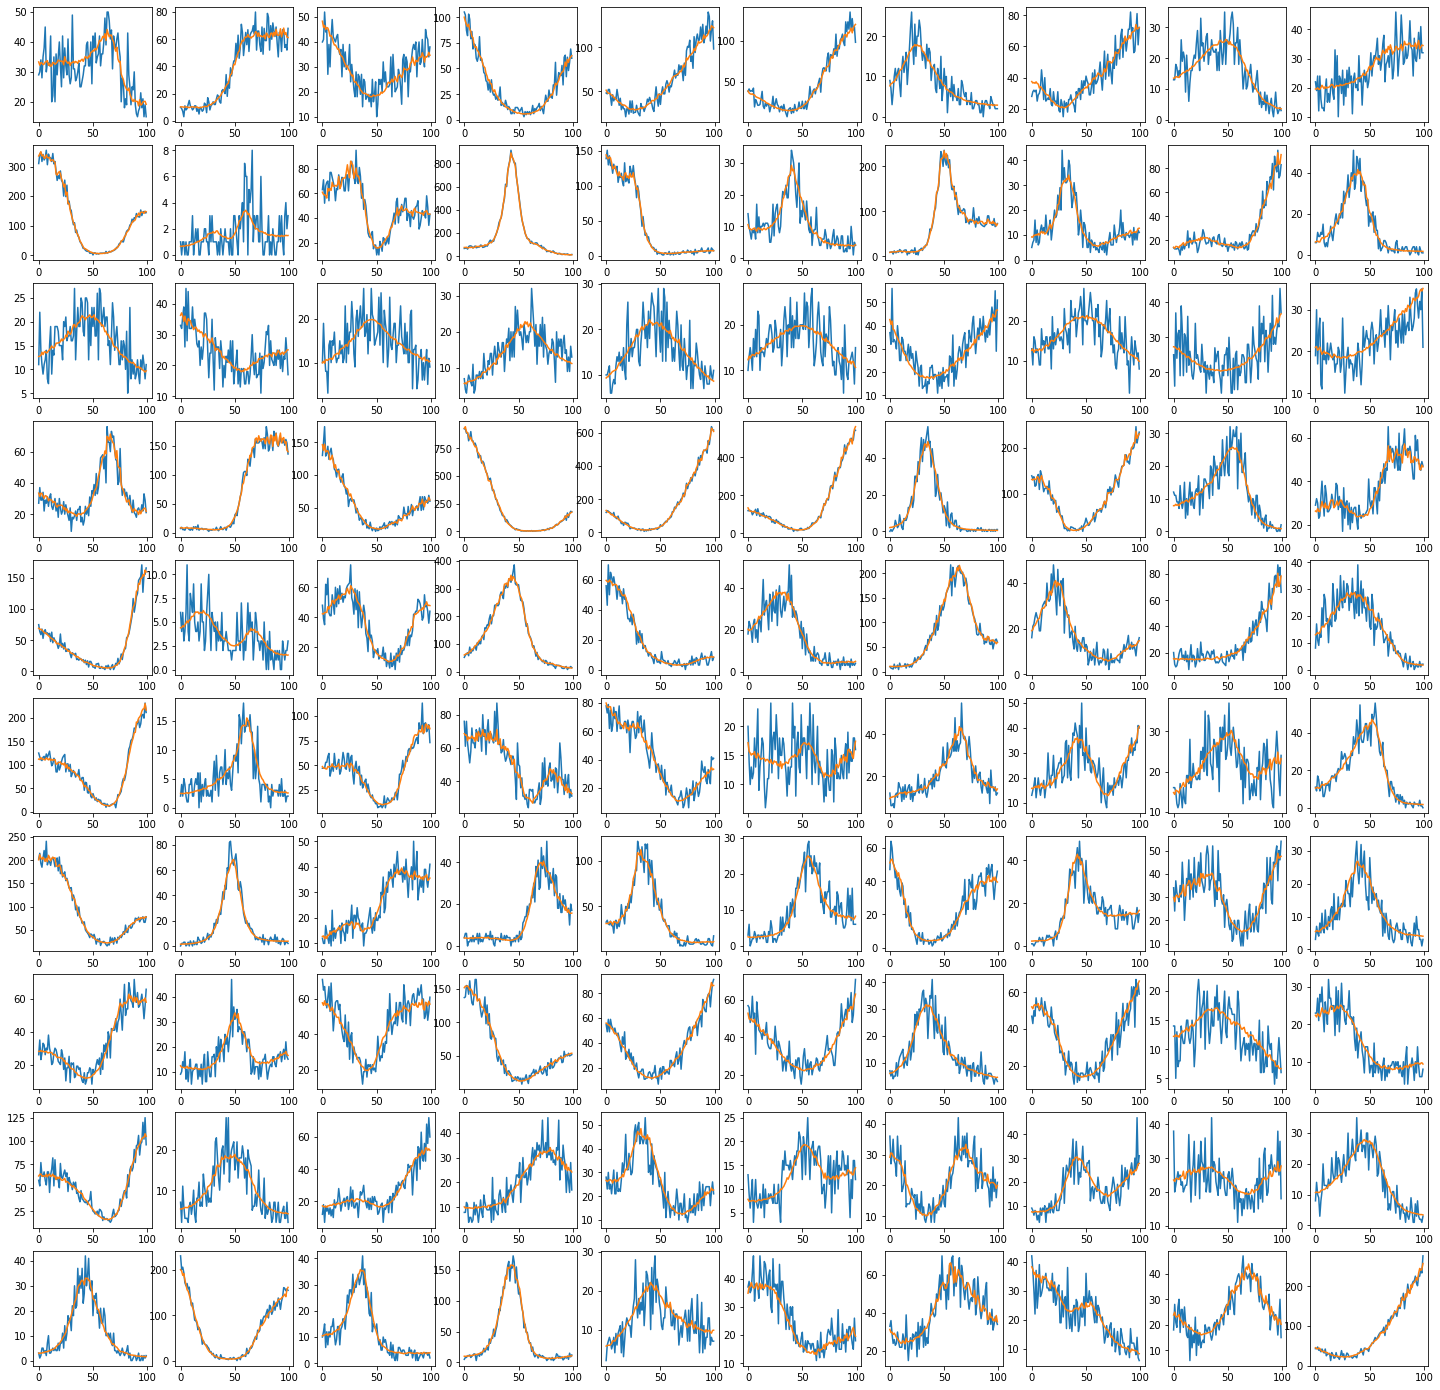

In [ ]:
Y = tf.reshape(Y, (n, s*r))
Y_est = tf.Variable(np.zeros(shape = (n, s*r)), dtype=tf.float32)
for t in range( n):
   Y_est[t, :].assign(h(X_kalman[t+1, :], c[t, :]))


n_plots = 10
i = tf.random.uniform(shape = [n_plots], maxval = s, dtype = tf.int32)
j = tf.random.uniform(shape = [n_plots], maxval = r, dtype = tf.int32)
fig, axs = plt.subplots(n_plots, n_plots, figsize=(25,25))
for i in range(n_plots):
  for j in range(n_plots):
    axs[ i, j].plot( Y[:, i + j*r ])
    axs[ i, j].plot( Y_est[:, i + j*r ])




In [ ]:
# fit a censored process
alpha = tf.constant(-3, dtype = tf.float32)
Y = np.zeros((n, s, r))
for t in range(n):
  Y[t, :, :]= tfd.Poisson(log_rate = alpha + tf.matmul(X_true[t,:s,:], X_true[t,s:,:], transpose_b=True)).sample(1)

Y = tf.reshape(Y, (n, s*r))


censor_data = get_censoring(Y)
Y = Y*censor_data

train_dataset = tf.data.Dataset.from_tensor_slices((Y, censor_data))
train_dataset = train_dataset.batch(batch_size=1)

model_coefficients = alpha
c = tf.Variable(tf.fill((n, s*r), model_coefficients), trainable=False)


model = Kalman_model(x_0, Sigma)
for iter in range(10):
  train_kalman(model)
  train_smoother(model)
  model_coefficients, log_likelihood = fit_glm(tf.reshape(Z, (-1,1)), tf.reshape(Y, [-1]), tf.reshape(offset, [-1]), censor_data)
  c.assign(tf.fill((n, s*r), model_coefficients))
  tf.print("log likelihood = ", tf.reduce_sum(log_likelihood))


forward filtering
backward smoothing
log likelihood =  -1814.8953265413484
forward filtering
backward smoothing
log likelihood =  -1816.1929541395684
forward filtering
backward smoothing
log likelihood =  -1815.03695617818
forward filtering
backward smoothing
log likelihood =  -1814.3167315823077
forward filtering
backward smoothing
log likelihood =  -1813.74353221962
forward filtering
backward smoothing
log likelihood =  -1813.2267140899653
forward filtering
backward smoothing
log likelihood =  -1812.7369469121222
forward filtering
backward smoothing
log likelihood =  -1812.264366888425
forward filtering
backward smoothing
log likelihood =  -1811.8053678467061
forward filtering
backward smoothing
log likelihood =  -1811.358383798595


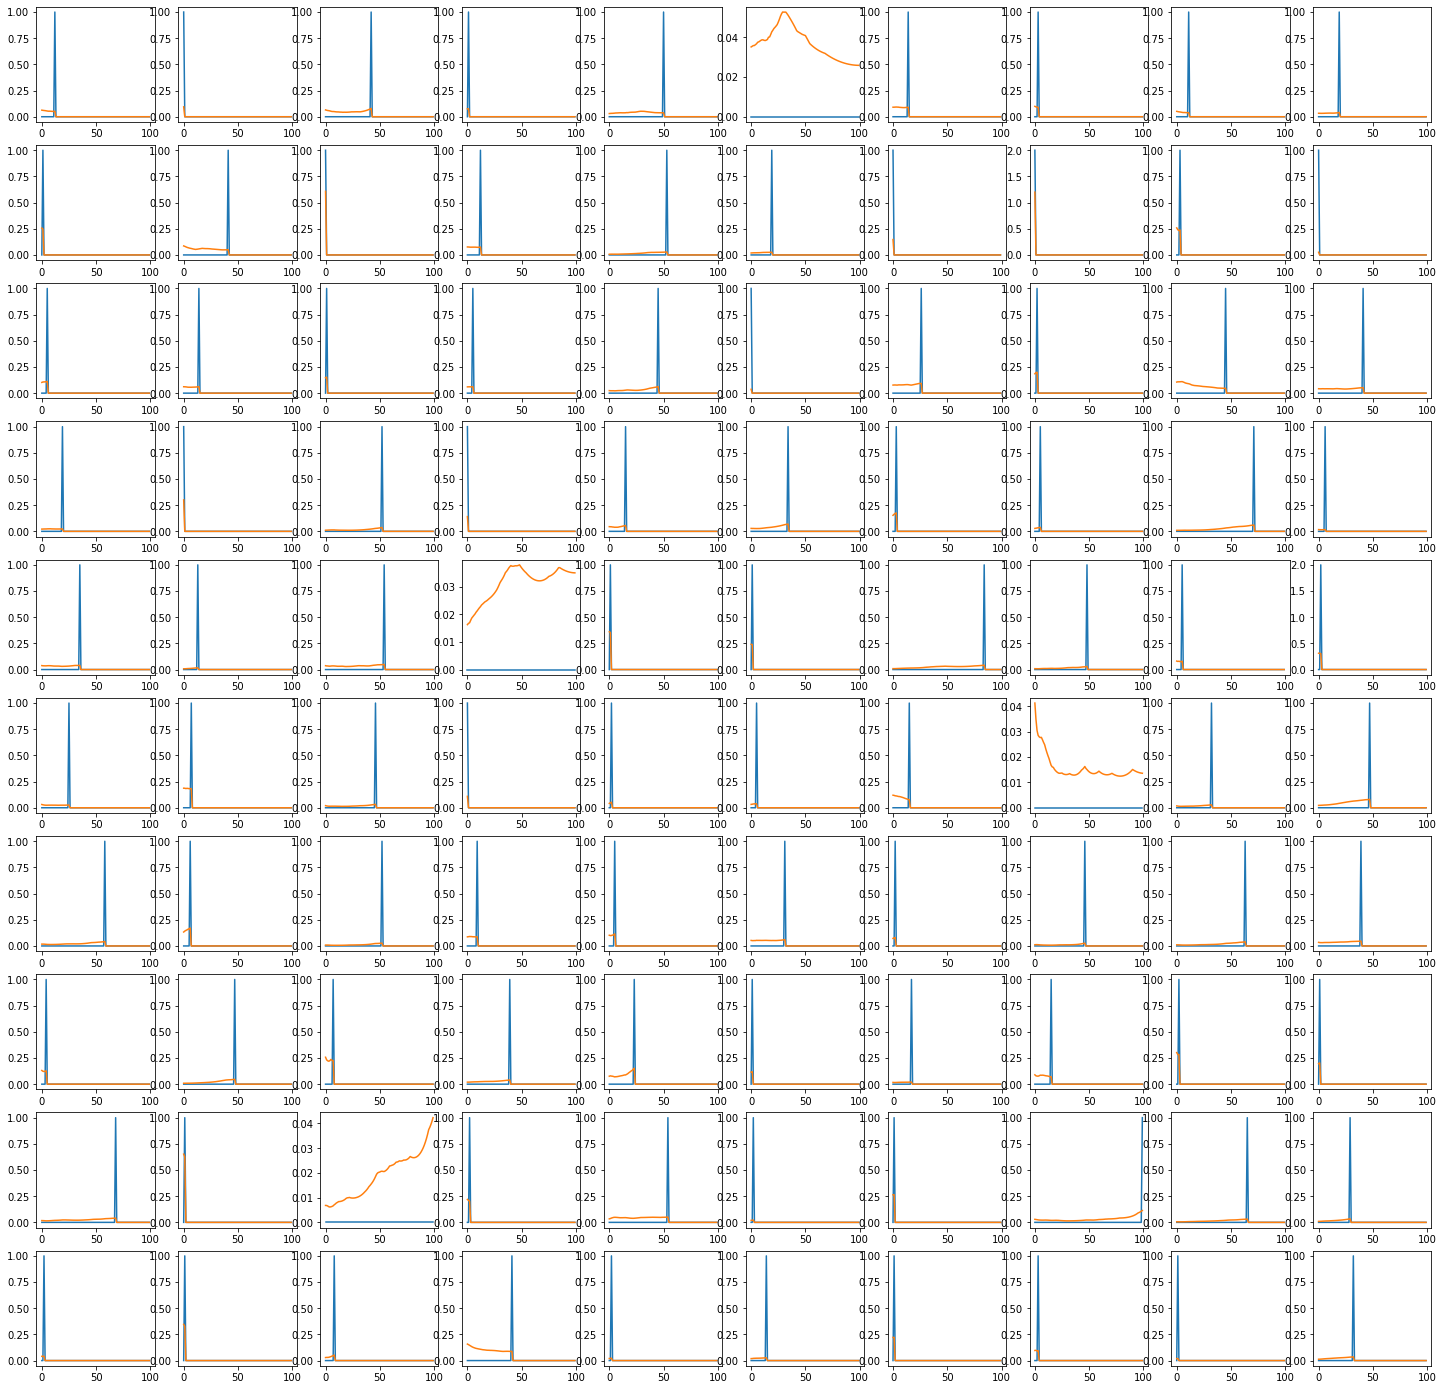

In [ ]:
Y = tf.reshape(Y, (n, s*r))
Y_est = tf.Variable(np.zeros(shape = (n, s*r)))
for t in range( n):
   Y_est[t, :].assign(h(X_kalman[t+1, :], c[t, :]))

Y_est = Y_est*censor_data
n_plots = 10
i = tf.random.uniform(shape = [n_plots], maxval = s, dtype = tf.int32)
j = tf.random.uniform(shape = [n_plots], maxval = r, dtype = tf.int32)
fig, axs = plt.subplots(n_plots, n_plots, figsize=(25,25))
for i in range(n_plots):
  for j in range(n_plots):
    axs[ i, j].plot( Y[:, i + j*r ])
    axs[ i, j].plot( Y_est[:, i + j*r ])



In [3]:
# particle filter should work well in GPU computing
# there is no bottleneck of matrix inversion

def h_b(X_b, b, c):
  species = tf.reshape(X_b[:, :(s*d)], (b, s, d))
  region = tf.reshape(X_b[:, (s*d):], (b, r, d))
  return tf.exp( c + tf.reshape(tf.matmul(species, region, transpose_b=True), (b, s*r)))


def Poisson_weight(y, X_b, c, b):
  mu_b = h_b(X_b, b, c)
  return tf.reduce_sum(-mu_b + y * tf.math.log(mu_b) , axis=1)
  

class Kalman_model(tf.Module):
  def __init__(self, x_0, sigma2):
    #super().__init__(**kwargs)
    self.x = tf.Variable(x_0)
    self.V = tf.Variable(sigma2)

  def __call__(self, y, c, censoring, b):
    X_b =  tf.reshape(self.x, [b, n_nodes*d]) + tf.sqrt(sigma2) * tf.random.normal(shape = [b, n_nodes*d], dtype = tf.float32)
    log_w = Poisson_weight(y, X_b, c, b)
    wh = tf.random.categorical(tf.reshape(log_w, (1, b)), b)
    self.x.assign(tf.reshape(tf.gather(X_b, wh), [-1]))
    return 

  def smoother(self, x_prev, V_prev):
    V_prior = V_prev + Sigma
    B = tf.matmul(V_prev, tf.linalg.inv(V_prior))
    self.x.assign(x_prev + tf.reshape(tf.matmul(B, tf.reshape(self.x - x_prev, (-1,1))), [-1]))
    V_tmp = V_prev + tf.matmul(tf.matmul(B, self.V - V_prior), B, transpose_b=True)
    self.V.assign( (V_tmp + tf.transpose(V_tmp))/2 )
    return 

@tf.function
def train_kalman(model):
  tf.print("forward filtering")
  for t, (y_batch, censor_batch) in enumerate(train_dataset):
    model(y_batch, c[t, :], censor_batch, b)
    X_kalman[t+1, :].assign(model.x)
    #V_kalman[t+1, :, :].assign(model.V)
    #tf.print(t)

censor_data = None

train_dataset = tf.data.Dataset.from_tensor_slices((Y, censor_data))
train_dataset = train_dataset.batch(batch_size=1)

# for t, (y_batch, censor_batch) in enumerate(train_dataset):
#   print(censor_batch)
#   print(y_batch)

b=1000
model_coefficients = alpha
c = tf.Variable(tf.fill((n, s*r), model_coefficients), trainable=False)
X_kalman = tf.Variable(tf.random.uniform(shape = (n+1,  n_nodes * d* b) , minval= -1, maxval= 1, dtype=tf.float32))
#V_kalman = tf.Variable(tf.random.uniform(shape = (n+1,  n_nodes * d, n_nodes * d) , minval= -1, maxval= 1, dtype=tf.float32))
offset = tf.Variable(tf.random.uniform(shape = (n, s*r ) , minval= -1, maxval= 1, dtype=tf.float32))
Z = tf.ones((n, s*r), dtype=tf.float32)

#x_0 = tf.random.uniform(shape = [n_nodes * d] , minval= -1, maxval= 1, dtype=tf.float32)
#Sigma = tf.cast(tf.linalg.diag([0.01]*(n_nodes*d).numpy()), dtype=tf.float32)
sigma2 = tf.constant(0.01, dtype=tf.float32)
x_0 = tf.reshape(X_true[0, :, :], -1) + tf.sqrt(sigma2 * 0.0000001) * tf.random.normal(shape = [b, n_nodes*d], dtype = tf.float32)

x_0 = tf.reshape(x_0, [-1])
X_kalman[0,:].assign(x_0)
#V_kalman[0,:,:].assign(Sigma)

model = Kalman_model(x_0, sigma2)

train_kalman(model)


sample = tf.random.categorical(tf.math.log([[0.05, 0.45]]), 1000)
tf.reduce_mean(tf.cast(sample, dtype=tf.float32))
for t in range(n+1):
  tf.reduce_mean(tf.reshape(X_kalman[t,:], [b, n_nodes*d]), axis=0)


  X_b =  tf.reshape(x_0, [b, n_nodes*d]) + tf.sqrt(sigma2) * tf.random.normal(shape = [b, n_nodes*d], dtype = tf.float32)
  log_w = Poisson_weight(Y[0, :], X_b, c[0,:], b)
  wh = tf.random.categorical(tf.reshape(log_w, (1, b)), b)
tf.gather(log_w, wh)


InvalidArgumentError: cannot compute AddV2 as input #1(zero-based) was expected to be a double tensor but is a float tensor [Op:AddV2]

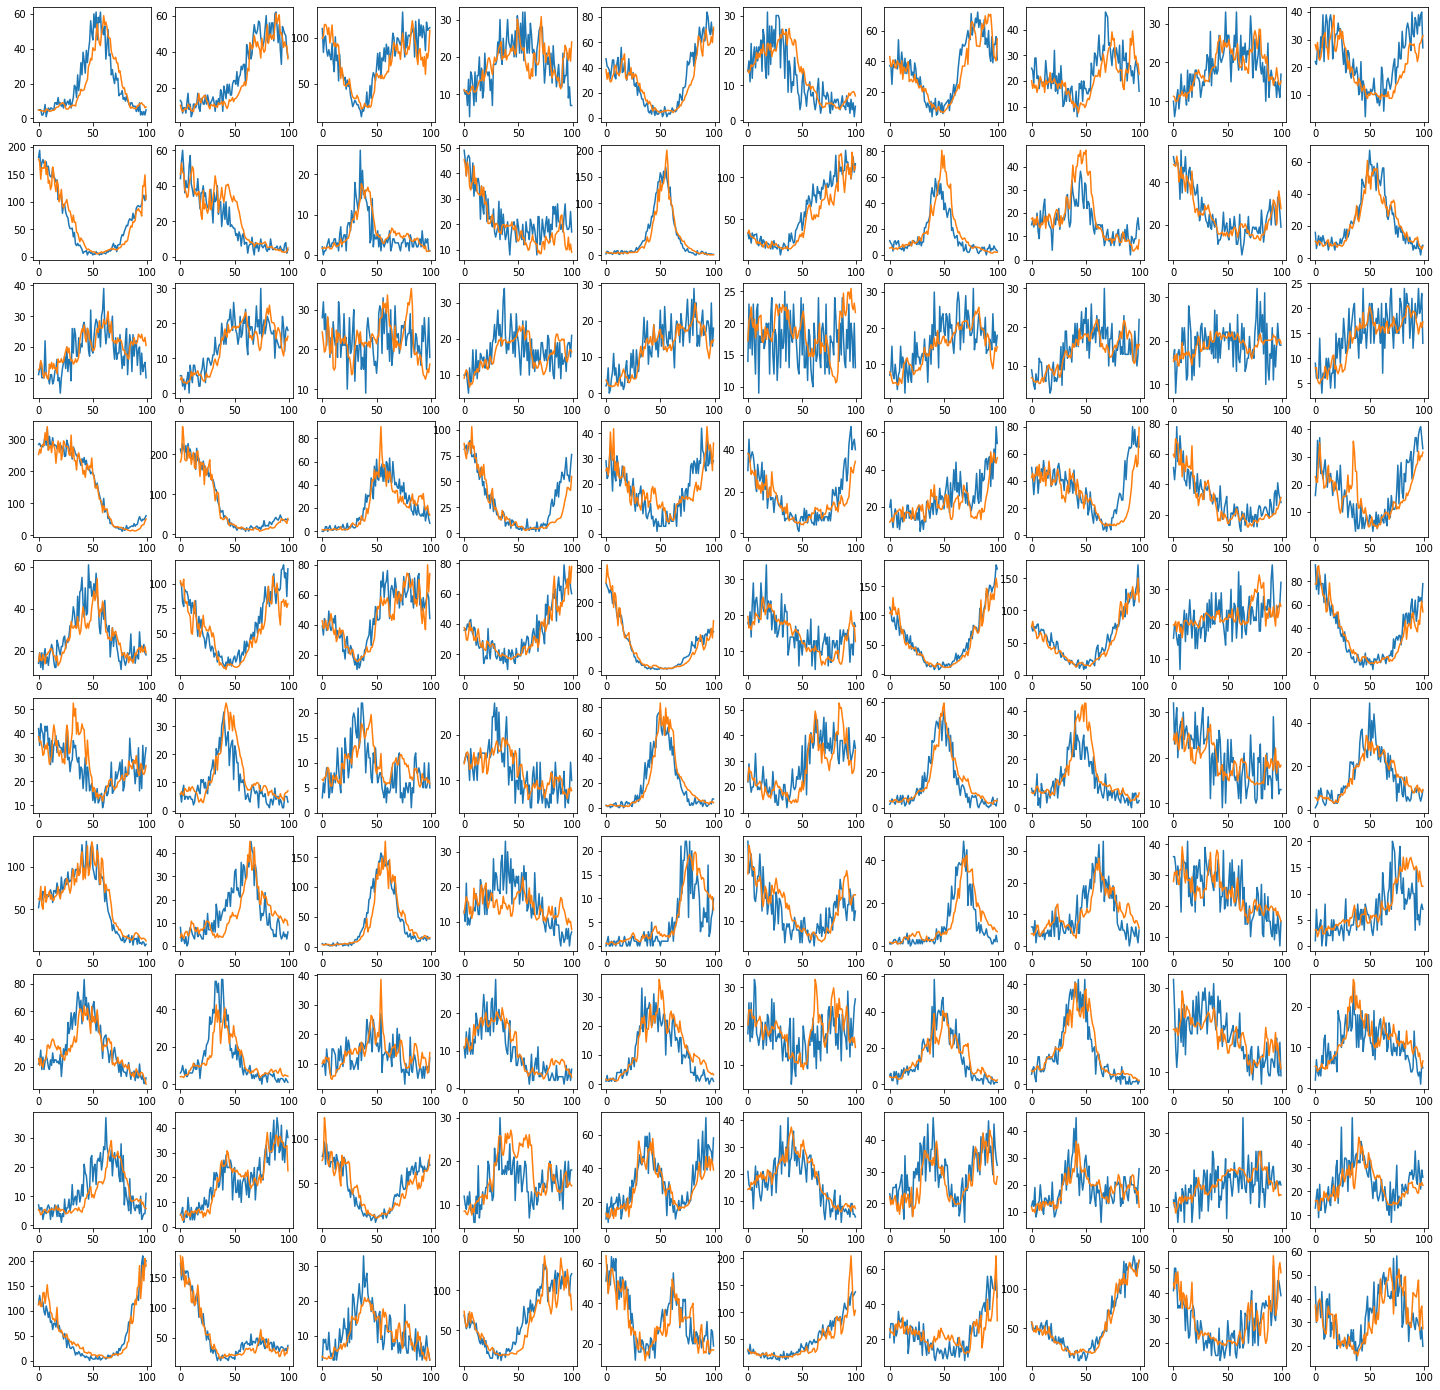

In [ ]:
Y = tf.reshape(Y, (n, s*r))
Y_est = tf.Variable(np.zeros(shape = (n, s*r)), dtype = tf.float32)
for t in range( n):
  x_tmp = tf.reduce_mean(tf.reshape(X_kalman[t+1,:], [b, n_nodes*d]), axis=0)
  Y_est[t, :].assign(h(x_tmp, c[t, :]))


n_plots = 10
i = tf.random.uniform(shape = [n_plots], maxval = s, dtype = tf.int32)
j = tf.random.uniform(shape = [n_plots], maxval = r, dtype = tf.int32)
fig, axs = plt.subplots(n_plots, n_plots, figsize=(25,25))
for i in range(n_plots):
  for j in range(n_plots):
    axs[ i, j].plot( Y[:, i + j*r ])
    axs[ i, j].plot( Y_est[:, i + j*r ])


ModuleNotFoundError: No module named 'nvidia_smi'

In [2]:

def h_b(X_b, b, c):
  species = tf.reshape(X_b[:, :(s*d)], (b, s, d))
  region = tf.reshape(X_b[:, (s*d):], (b, r, d))
  return tf.exp( c + tf.reshape(tf.matmul(species, region, transpose_b=True), (b, s*r)))

def h(x, c):
  species = tf.reshape(x[:(s*d)], (s, d))
  region = tf.reshape(x[(s*d):], (r, d))
  return tf.exp( c + tf.reshape(tf.matmul(species, region, transpose_b=True), [-1]))

def get_offset(x):
  species = tf.reshape(x[:(s*d)], (s, d))
  region = tf.reshape(x[(s*d):], (r, d))
  return tf.reshape(tf.matmul(species, region, transpose_b=True), [-1])

@tf.function
def get_h_H(x, c): 
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(x)
    h_current = h(x, c)
  H = tape.jacobian(target = h_current, sources = x, parallel_iterations=500 , experimental_use_pfor=True)
  return h_current, H


def get_censoring(Y):
  censoring = tf.Variable(np.ones((n, s*r)), dtype = tf.float32)
  for t in range(1,n):
    censoring[t, :].assign(censoring[t-1, :]-Y[t-1, :])
  return tf.keras.activations.relu(censoring)

class Kalman_model(tf.Module):
  def __init__(self, x_0, sigma2):
    #super().__init__(**kwargs)
    self.x = tf.Variable(x_0)
    self.V = tf.Variable(sigma2)
    #self.H = tf.Variable(tf.zeros((s*r, n_nodes*d)))

  def __call__(self, y, c, censoring):
    self.V.assign_add(sigma2)
    mu, H = get_h_H(self.x, c)
    # X_b =  tf.reshape(self.x, [b, n_nodes*d]) + tf.sqrt(sigma2) * tf.random.normal(shape = [b, n_nodes*d], dtype = tf.float32)
    # Y_b = h_b()
    R_inv = 1/mu
    if(censoring != None):
      censoring = tf.squeeze(censoring)
      H = tf.matmul(tf.linalg.diag(censoring), H)
      R_inv = 1/mu * censoring
      mu = mu * censoring
    S_chol = tf.linalg.cholesky(tf.linalg.diag(1/self.V) + tf.matmul(H, tf.transpose(R_inv * tf.transpose(H)), transpose_a=True))
    K = tf.linalg.cholesky_solve(S_chol, R_inv * tf.transpose(H))
    #K = tf.matmul(tf.linalg.inv(tf.linalg.diag(1/self.V) + tf.matmul(H, tf.matmul(R_inv, H), transpose_a=True)), tf.matmul(H, R_inv, transpose_a=True))
    self.x.assign_add( tf.squeeze(tf.matmul(K, tf.reshape(y - mu, (-1,1)))))
    self.V.assign((tf.cast(1, dtype=tf.float32) - tf.reduce_sum(K*tf.transpose(H), axis=1)) *self.V)
    return 

  def smoother(self, x_prev, V_prev):
    V_prior = V_prev + sigma2
    B = V_prev/V_prior
    self.x.assign(x_prev + tf.squeeze(B * tf.squeeze(self.x - x_prev)))
    self.V.assign( V_prev + tf.square(B)*(self.V - V_prior))
    return 

#train_dataset_rev = tf.data.Dataset.from_tensor_slices(tf.reverse(Y, axis=[0]))
#train_dataset_rev = train_dataset.batch(batch_size=1)

@tf.function
def train_kalman(model):
  tf.print("forward filtering")
  for t, (y_batch, censor_batch) in enumerate(train_dataset):
    model(y_batch, c[t, :], censor_batch)
    X_kalman[t+1, :].assign(model.x)
    V_kalman[t+1, :].assign(model.V)
    tf.print(t)


@tf.function
def train_smoother(model):
  tf.print("backward smoothing")
  for t, (y_batch, censor_batch) in enumerate(train_dataset):
    t = n-tf.cast(t, dtype=tf.int32)
    if(t!=0):
      offset[t-1, :].assign(get_offset(model.x))
    model.smoother(X_kalman[t-1, :], V_kalman[t-1, :])
    X_kalman[t-1, :].assign(model.x)
    V_kalman[t-1, :].assign(model.V)
    tf.print(t)

@tf.function(autograph=False)
def fit_glm(z, y, offset, censor_data):
  if(censor_data != None):
    wh = tf.squeeze(tf.where(tf.reshape(censor_data, [-1])==1))
    z = tf.gather(z, wh, axis=0)
    y = tf.gather(y, wh, axis=0)
    offset = tf.gather(offset, wh, axis=0)
  model_coefficients, linear_response, is_converged, num_iter = tfp.glm.fit(model_matrix=z, response=y, model=tfp.glm.Poisson(), offset = offset )
  log_likelihood = tfp.glm.Poisson().log_prob(y, linear_response)
  return (model_coefficients, log_likelihood)


censor_data = None

train_dataset = tf.data.Dataset.from_tensor_slices((Y, censor_data))
train_dataset = train_dataset.batch(batch_size=1)

# for t, (y_batch, censor_batch) in enumerate(train_dataset):
#   print(censor_batch)
#   print(y_batch)

model_coefficients = alpha
c = tf.Variable(tf.fill((n, s*r), model_coefficients), trainable=False)
X_kalman = tf.Variable(tf.random.uniform(shape = (n+1,  n_nodes * d) , minval= -1, maxval= 1, dtype=tf.float32))
V_kalman = tf.Variable(tf.random.uniform(shape = (n+1,  n_nodes * d) , minval= -1, maxval= 1, dtype=tf.float32))
offset = tf.Variable(tf.random.uniform(shape = (n, s*r ) , minval= -1, maxval= 1, dtype=tf.float32))
Z = tf.ones((n, s*r), dtype=tf.float32)

#x_0 = tf.random.uniform(shape = [n_nodes * d] , minval= -1, maxval= 1, dtype=tf.float32)
x_0 = tf.reshape(X_true[0, :, :], -1)
sigma2 = tf.constant( [0.01]*(n_nodes*d).numpy(), dtype=tf.float32)

X_kalman[0,:].assign(x_0)
V_kalman[0,:].assign(sigma2)

model = Kalman_model(x_0, sigma2)
#tf.config.run_functions_eagerly(False)
for iter in range(2):
  train_kalman(model)
  train_smoother(model)
  model_coefficients, log_likelihood = fit_glm(tf.reshape(Z, (-1,1)), tf.reshape(Y, [-1]), tf.reshape(offset, [-1]), censor_data)
  c.assign(tf.fill((n, s*r), model_coefficients))
  tf.print("log likelihood = ", tf.reduce_sum(log_likelihood))





forward filtering
0
1


2022-04-27 17:14:17.261649: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x55649ef3a4f0


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
backward smoothing
100
99
98
97
96
95
94
93
92
91
90
89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Instructions for updating:
The `interpolate_nondiscrete` flag is deprecated; instead use `force_probs_to_zero_outside_support` (with the opposite sense).
log likelihood =  -7234141.5
forward filtering
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70

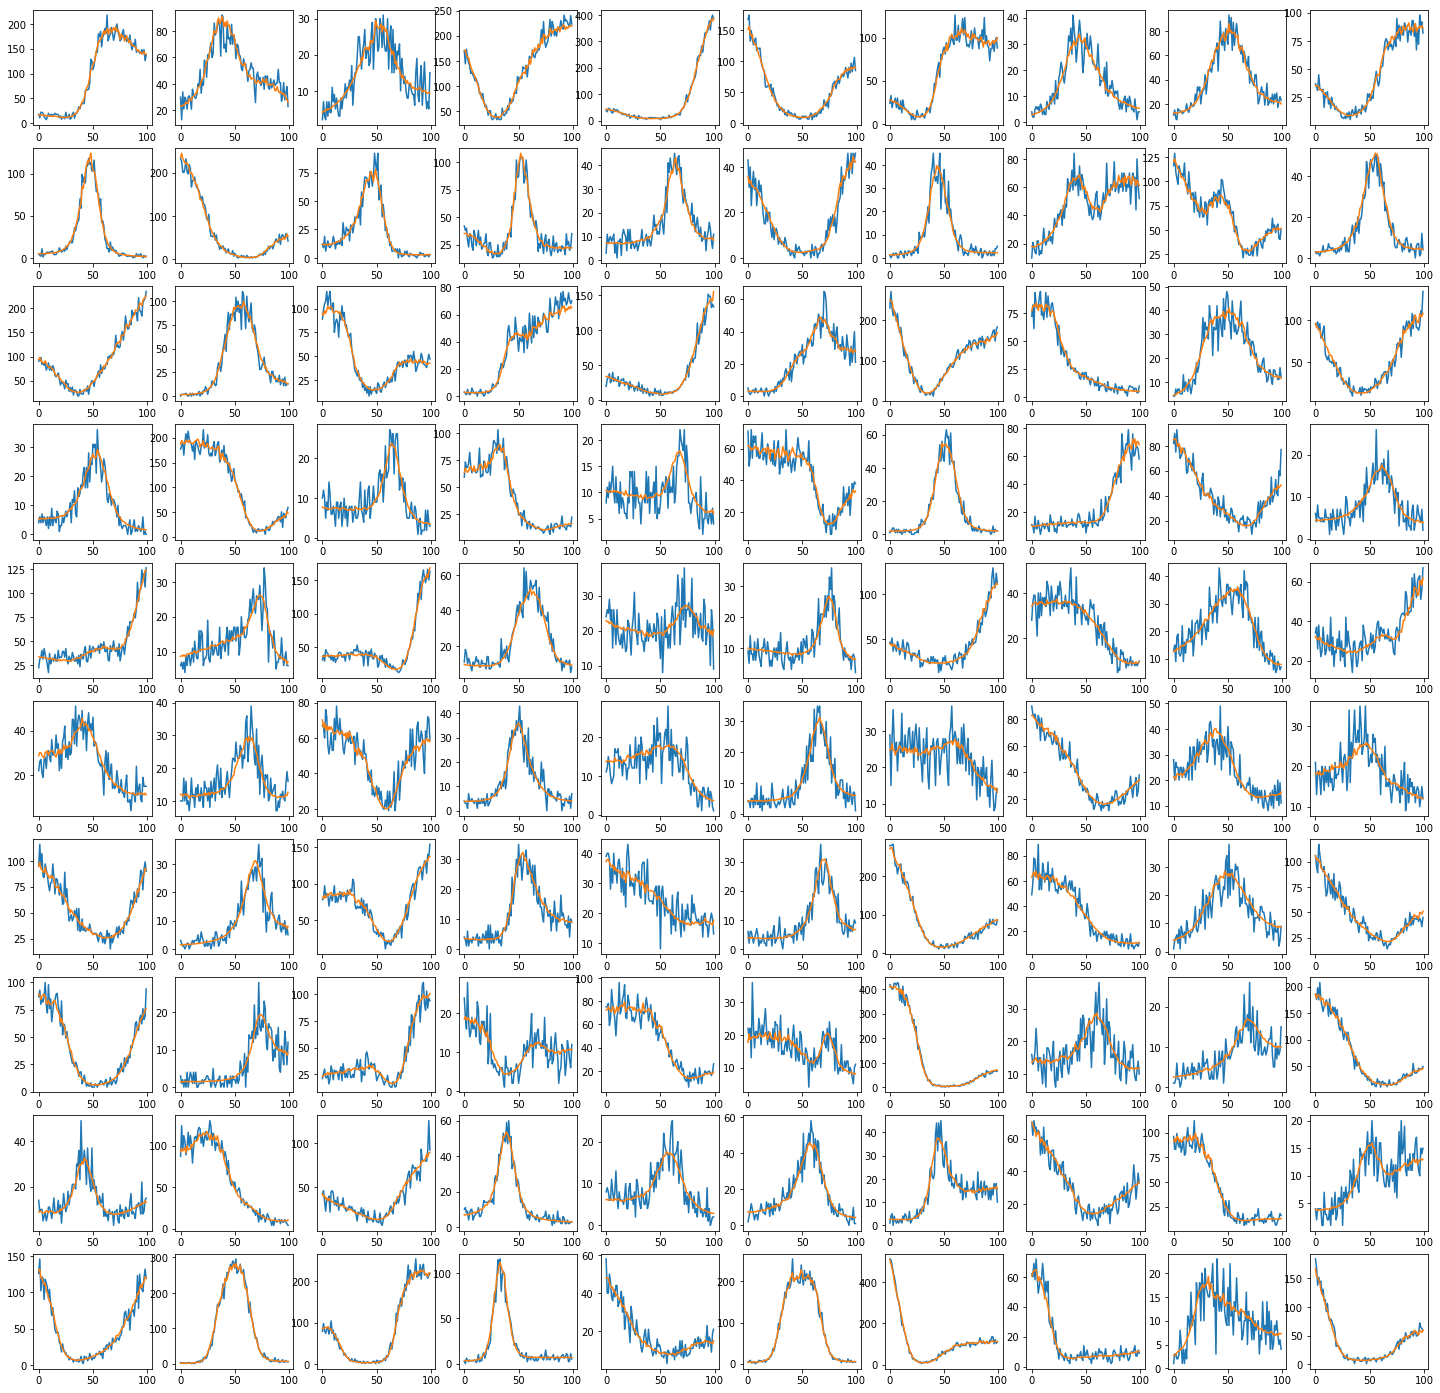

In [3]:
Y = tf.reshape(Y, (n, s*r))
Y_est = tf.Variable(np.zeros(shape = (n, s*r)), dtype=tf.float32)
for t in range( n):
   Y_est[t, :].assign(h(X_kalman[t+1, :], c[t, :]))


n_plots = 10
i = tf.random.uniform(shape = [n_plots], maxval = s, dtype = tf.int32)
j = tf.random.uniform(shape = [n_plots], maxval = r, dtype = tf.int32)
fig, axs = plt.subplots(n_plots, n_plots, figsize=(25,25))
for i in range(n_plots):
  for j in range(n_plots):
    axs[ i, j].plot( Y[:, i + j*r ])
    axs[ i, j].plot( Y_est[:, i + j*r ])
